# A Machine learning problem: reduced order modelling and video prediction
Data: 48 videos are available, describing the evolution of a physical field with different initial conditions. Each video is of dimension 128 * 128 * 16 (timesteps) with binary pixel values. For all the tasks please use the first 40 videos as training (including validation) data and the rest 8 as test data

##### Q1 Perform the Principle component analysis of the training dataset where each snapshot (i.e., image) is considered as a sample. Use the principle component for data compressing and decompressing.

1. Convert mp4 to frame png files
2. Perform PCA to compress data



##### Step 1: Import libraries and visualise data

In [1]:
import cv2
import os
from sklearn.decomposition import PCA 
import numpy as np 
import imageio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import random

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [2]:
videos = np.zeros((49, 16, 128, 128))


for i in range(49):
    path = 'data/video_' + str(i)
    
    if not os.path.exists(path):
        os.mkdir(path)
    else:
        print("Folder already exists")

    vid = cv2.VideoCapture('videos/fire_Chimney_video_' + str(i) + '.mp4')
    print(int(vid.get(cv2.CAP_PROP_FRAME_COUNT)))


    frames = np.zeros((16, 128, 128))

    currentframe = 0

    for j in range(16):

        ret, frame = vid.read()

        if ret == False:
            vid.release()
            print(str(j) + " fail")
            break


        else:
            name = 'data/video_' + str(i) + '/' + str(j) +  ".png"
            g_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(name, g_frame)
            frames[j,:,:] = np.array(g_frame)


            print(str(j) + " success")

        cv2.destroyAllWindows()

    videos[i,:,:,:] = frames


print(videos.shape)


Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
Folder already exists
16
0 success
1 success


#### Video 1 pre-PCA

(16, 128, 128)


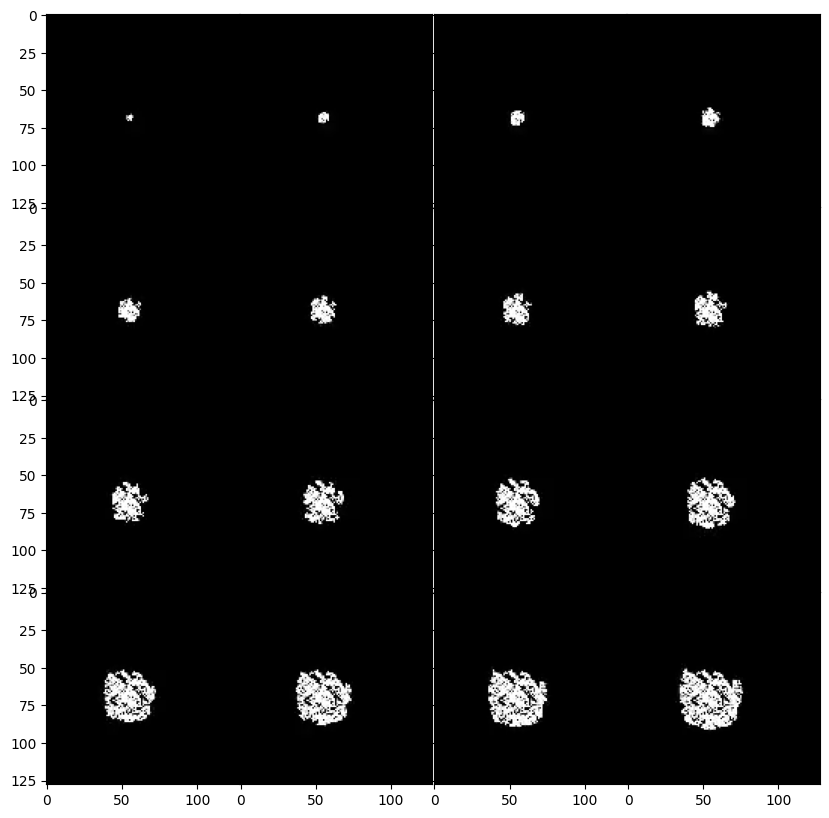

In [3]:
video_0 = videos[0,:,:,:]

video_0.reshape((128, 128, 16))
print(video_0.shape)

def display_frames(video):
    fig, axs = plt.subplots(4, 4, sharey = True, sharex = True, figsize = (10,10))
    fig.subplots_adjust(wspace = 0, hspace = 0)


    for i in range(4):
        axs[i][0].imshow((video[(4*i),:,:]), cmap = 'grey')
        axs[i][1].imshow((video[4*(i)+1,:,:]), cmap = 'grey')
        axs[i][2].imshow((video[4*(i)+2,:,:]), cmap = 'grey')
        axs[i][3].imshow((video[4*(i)+3,:,:]), cmap = 'grey')
        
display_frames(video_0)

#### PCA on video 1

(16, 16384)
(16, 8)
(16, 128, 128)
0.0


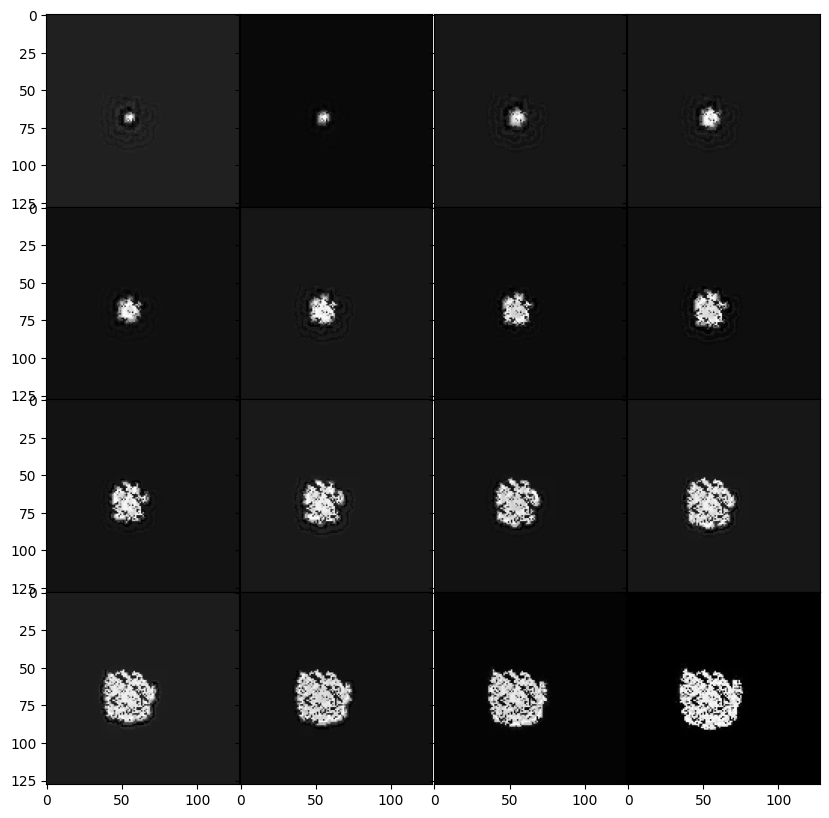

In [4]:
def vid_pca(video, n_components = 16):
    no_frames, height, width = video.shape
    vid_matrix = video.reshape(no_frames,-1)

    print(vid_matrix.shape)


    pca = PCA(n_components= n_components)
    comp = pca.fit_transform(vid_matrix)

    print(comp.shape)

    decomp = pca.inverse_transform(comp)
    decomp = decomp.reshape(no_frames, height, width)

    print(decomp.shape)

    return decomp

vid_0 = vid_pca(video_0, 8)

display_frames(vid_0)

print(video_0[15, 1, 1])



#### TODO:
-	For a random video in the dataset: display the frames before PCA, PCA with 1,4,8,12 and 16 components
- Image compression using convolutional autoencoder
- perform thresholding for binary pixel values

In [5]:
print(torch.__version__)

2.2.1+cu118


In [9]:
class CAE(nn.Module):
    def __init__(self, orig_dim, batch_size):
        super(CAE, self).__init__()
        
        n = 2
        flat_size =  torch.numel(orig_dim)*2
        

        self.conv1 = nn.Sequential(
            
            nn.Conv3d(1 ,n, kernel_size= 3, padding =1), 
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential( 
            nn.Conv3d(n ,2*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(2*n ,4*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
        )

        self.conv4 = nn.Sequential(
            nn.Conv3d(4*n ,8*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(8*n),
            nn.ReLU(),
        )

        self.conv5 = nn.Sequential(
            nn.Conv3d(8*n ,16*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(16*n),
            nn.ReLU(),


            nn.Flatten(),


        )


        self.transconv1 = nn.Sequential(
            
            nn.Unflatten(1, (16*n ,orig_dim.shape[2]//16, orig_dim.shape[3]//16, orig_dim.shape[4]//16)),
            
            nn.ConvTranspose3d(16*n, 8*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(8*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(8*n,8*n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(8*n),
            nn.ReLU(),   
        )
    
        self.transconv2 = nn.Sequential(
            nn.ConvTranspose3d(16*n, 4*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(4*n,4*n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
        )

        self.transconv3 = nn.Sequential(
            
            nn.ConvTranspose3d(8*n, 2*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(2*n,2*n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            
        )

        self.transconv4 = nn.Sequential(     
            nn.ConvTranspose3d(4*n, n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(n,n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.transconv5 = nn.Sequential(
            nn.ConvTranspose3d(2*n, 1, kernel_size =3, padding =1),
            nn.BatchNorm3d(1),
            nn.ReLU(),
            
            nn.ConvTranspose3d(1,1, kernel_size=3, padding =1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )


        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_uniform_(m.weight)


    def forward(self, x):
        # print("0 " + str(x.shape))
        x = self.conv1(x)
        # print("1")
        self.skip_1 = x
        # print("2")

        x = self.conv2(x)
        # print("3")

        self.skip_2 = x
        # print("4")

        x = self.conv3(x)
        # print("5")
        self.skip_3 = x
        # print("6")

        x = self.conv4(x)
        # print("7")
        self.skip_4 = x
        # print("8 " + str(x.shape))

        x = self.conv5(x)

        # print("9 " + str(x.shape))

        
        x = self.transconv1(x)
        # print("10 " + str(x.shape))

        x = torch.cat((x, self.skip_4),dim = 1)
        # print("11 " + str(x.shape)) 
        
        x = self.transconv2(x)
        # print("12 " + str(x.shape))
        
        x = torch.cat((x, self.skip_3),dim = 1)
        # print("13 " + str(x.shape))
        
        x = self.transconv3(x)
        # print("14 " + str(x.shape))
        
        x = torch.cat((x, self.skip_2),dim = 1)
        # print("15 " + str(x.shape))
        
        x = self.transconv4(x)
        # print("16 " + str(x.shape))
        
        x = torch.cat((x, self.skip_1),dim = 1)
        # print("17 " + str(x.shape))

        x = self.transconv5(x)
        # print("18 " + str(x.shape))

        return x

    def enc_out(self, data):
        self.eval()
        with torch.no_grad():

            x = self.conv1(data)

            x = self.conv2(x)

            x = self.conv3(x)

            x = self.conv4(x)

            x = self.conv5(x)

                
            return x
        
    def dec_out(self,x):
        self.eval()
        with torch.no_grad():
            
            x = self.transconv1(x)
            x = torch.cat((x, self.skip_4),dim = 1)
            
            x = self.transconv2(x)
            x = torch.cat((x, self.skip_3),dim = 1)
                    
            x = self.transconv3(x)
            x = torch.cat((x, self.skip_2),dim = 1)
                    
            x = self.transconv4(x)
            x = torch.cat((x, self.skip_1),dim = 1)
            
            x = self.transconv5(x)
        
        return x




norm_vids = videos/255.0

vids_tensor = torch.unsqueeze(torch.Tensor(norm_vids,), 1)

train_norm_vids = vids_tensor[:8, :, :, :,:]
test_norm_vids =  vids_tensor[-8:, :, :, :,:]

indices = torch.randperm(len(train_norm_vids))
train_norm_vids = train_norm_vids[indices]


print(len(train_norm_vids))
print(train_norm_vids.shape)

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))


no_epochs = 150
batch_size = 4

cae_model = CAE(train_norm_vids[0:4,:,:,:,:], batch_size)
cae_model = cae_model.to(device)

criterion = nn.MSELoss()
optimiser = torch.optim.Adam(list(cae_model.parameters()), lr = 0.05)




for epoch in range(no_epochs):

    for i in range(0,len(train_norm_vids), batch_size):
        
        cae_model.train()
        
        batch = train_norm_vids[i:i+batch_size]
        batch = batch.to(device, dtype = torch.float32)
        
        optimiser.zero_grad()
        train_recon = cae_model(batch)
        
        loss = criterion(train_recon, batch)
        loss.backward()
        
        optimiser.step()
    
    cae_model.eval()

    with torch.no_grad():
        test_norm_vids = test_norm_vids.to(device, dtype = torch.float32)
        test_recon = cae_model(test_norm_vids)
        test_loss = criterion(test_recon, test_norm_vids)
        print("Test loss at epoch {0}: ".format(epoch+1) + str(test_loss.item()))

        



8
torch.Size([8, 1, 16, 128, 128])
2.2.1+cu118
Device: cuda
Test loss at epoch 1: 0.9795185327529907
Test loss at epoch 2: 0.9865670800209045
Test loss at epoch 3: 0.9860934019088745
Test loss at epoch 4: 0.959151566028595
Test loss at epoch 5: 0.6461862921714783
Test loss at epoch 6: 0.13306573033332825
Test loss at epoch 7: 0.09244082868099213
Test loss at epoch 8: 0.07697658985853195
Test loss at epoch 9: 0.06667673587799072
Test loss at epoch 10: 0.058545585721731186
Test loss at epoch 11: 0.05102963000535965
Test loss at epoch 12: 0.04528220742940903
Test loss at epoch 13: 0.04045151546597481
Test loss at epoch 14: 0.03510335460305214
Test loss at epoch 15: 0.031461723148822784
Test loss at epoch 16: 0.029295090585947037
Test loss at epoch 17: 0.027355719357728958
Test loss at epoch 18: 0.02645714208483696
Test loss at epoch 19: 0.025530431419610977
Test loss at epoch 20: 0.025394005700945854
Test loss at epoch 21: 0.024683216586709023
Test loss at epoch 22: 0.024175560101866722
T

- The size of each video before passing through the encoder has a shape of 16x128x128 = 262144
- The size of each video after passing through the encoder of the CAE is 2048
- This means that using the CAE, we can achieve a 99.2% reduction in information required to represent the evolving field in each video


(8, 16, 128, 128)


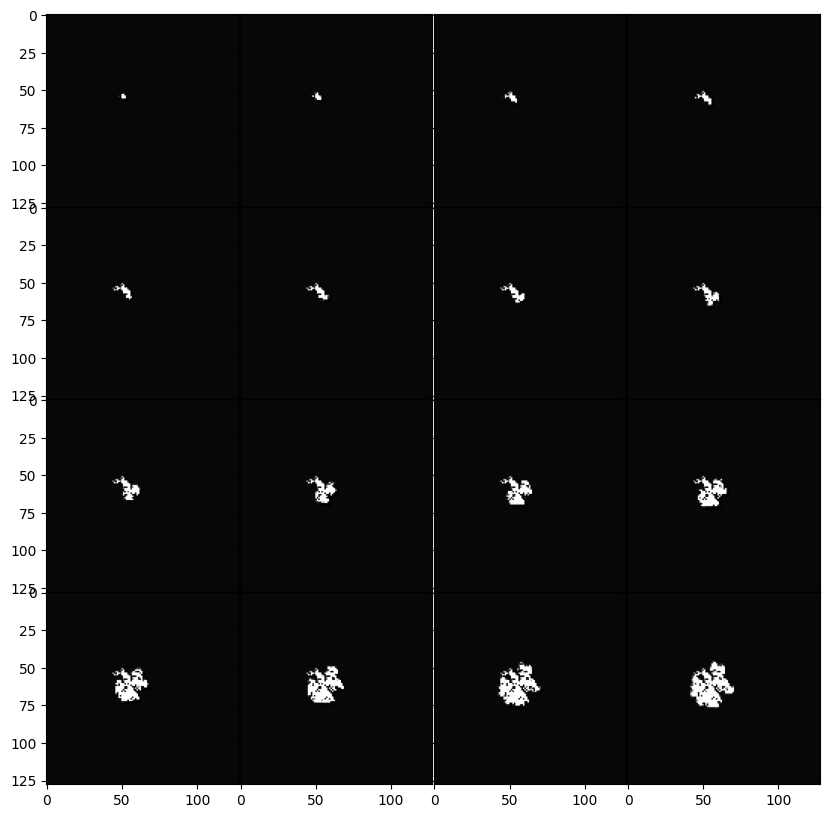

In [7]:
results = torch.squeeze(test_recon,1).cpu().numpy()
print(results.shape)
display_frames(results[5,:,:,:])
# torch.save(cae_model, "trained_cae.pt")
# model = torch.load("trained_cae.pt")
# model.eval()

In [8]:
with torch.no_grad():
    meow = model(test_norm_vids)

peak = torch.squeeze(meow,1).cpu().numpy()
print(peak.shape)
display_frames(peak[4,:,:,:])

NameError: name 'model' is not defined

Use CAE encoder output as input into LSTM to predict sequence to sequence LSTM in reduced space and use decoder to decode results in full space

Break down videos into 4 frame chunks of inputs and labels:

In [ ]:
print(videos.shape)

# using videos 8-40 for training
train = videos[8:-9, :, :, :]
test = videos[-9:, :, :, :]

train = train/255.0
test = test/255.0

def vid2seq(videos):
    
    in_seqs = np.ndarray(shape = (videos.shape[0]*9,4,128,128))
    out_seqs = np.ndarray(shape = (videos.shape[0]*9,4,128,128))

    for i in range(videos.shape[0]):
        for j in range (videos.shape[1]-7):
            in_seqs[(i*9)+j,:,:,:] = videos[i,j:4+j,:,:]
            out_seqs[(i*9)+j,:,:,:] = videos[i,4+j:8+j,:,:]

    return in_seqs, out_seqs

train_seqs_in, train_seqs_out = vid2seq(train)
test_seqs_in, test_seqs_out = vid2seq(test)

print(train_seqs_out.shape)
print(test_seqs_out.shape)

(49, 16, 128, 128)
(288, 4, 128, 128)
(81, 4, 128, 128)


Visualise input sequence and output sequence of a random subset of the data

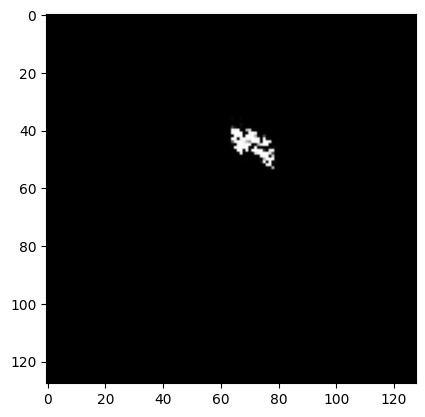

In [ ]:
# def display_seq(seq):
#     fig, axs = plt.subplots(1, 4, sharey = True, sharex = True, figsize = (10,10))
#     fig.subplots_adjust(wspace = 0, hspace = 0)


#     for i in range(4):
#         axs[i].imshow((seq[i,:,:]), cmap = 'grey')

        

# display_seq(test_seqs_in[55,:,:,:]*255.0)        
        
plt.imshow(test_seqs_in[5,3,:,:]*255.0, cmap = "grey")

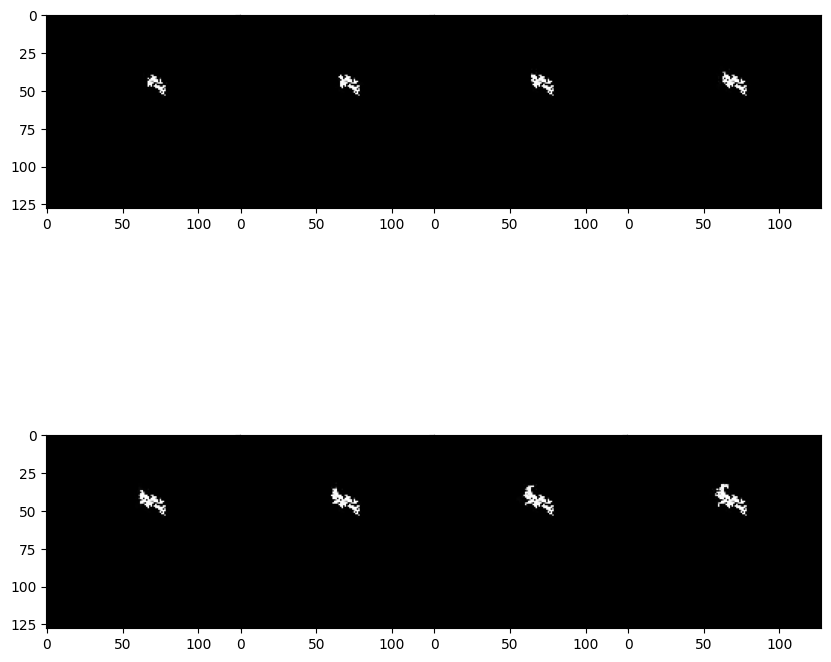

In [ ]:
def display_seq(seq_in, seq_out):
    fig, axs = plt.subplots(2, 4, sharey = True, figsize = (10,10))
    fig.subplots_adjust(wspace = 0)


    for i in range(4):
        axs[0][i].imshow(seq_in[i,:,:], cmap = 'grey')
        axs[1][i].imshow(seq_out[i,:,:], cmap = 'grey')

display_seq(test_seqs_in[6,:,:,:]*255.0,test_seqs_out[6,:,:,:])

      

In [ ]:
class seq_CAE(nn.Module):
    def __init__(self, orig_dim, batch_size):
        super(seq_CAE, self).__init__()
        
        n = 1
        flat_size =  torch.numel(orig_dim)*2
        

        self.conv1 = nn.Sequential(
            
            nn.Conv3d(1 ,n, kernel_size= 3, padding =1), 
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential( 
            nn.Conv3d(n ,2*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv3d(2*n ,4*n, kernel_size= 3,stride =2, padding =1),            
            nn.BatchNorm3d(4*n),
            nn.ReLU(),
            nn.Flatten(),

            # nn.Conv3d(4*n,4*n, kernel_size = 3, stride =2, padding =1),
        )

        # self.conv4 = nn.Sequential(
        #     nn.Conv3d(4*n ,8*n, kernel_size= 3,stride =(1,2,2), padding =1),            
        #     nn.BatchNorm3d(8*n),
        #     nn.ReLU(),
        #     nn.Flatten(),

        # )

        self.comp = nn.Sequential(
            nn.Linear(4096,50)

        )

        self.decomp = nn.Sequential(
            nn.Linear(50,4096)
        )


        # self.transconv2 = nn.Sequential(
            
        #     nn.Unflatten(1, (8*n ,orig_dim.shape[2]//4, orig_dim.shape[3]//8, orig_dim.shape[4]//8)),
        #     nn.ConvTranspose3d(8*n, 4*n, kernel_size=3, stride =(2,2,2) ,padding = 1, output_padding=(1,1,1)),
        #     nn.BatchNorm3d(4*n),
        #     nn.ReLU(),
            
        #     nn.ConvTranspose3d(4*n,4*n,kernel_size=3, padding= 1, output_padding=1),
        #     nn.BatchNorm3d(4*n),
        #     nn.ReLU(),
            
        # )

        self.transconv3 = nn.Sequential(

            nn.Unflatten(1, (4*n ,orig_dim.shape[2]//4, orig_dim.shape[3]//4, orig_dim.shape[4]//4)),
            nn.ConvTranspose3d(4*n, 2*n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(2*n,2*n,kernel_size=3, padding =1),
            nn.BatchNorm3d(2*n),
            nn.ReLU(),
            
        )

        self.transconv4 = nn.Sequential(   

            nn.ConvTranspose3d(4*n, n, kernel_size=3, stride =2 ,padding = 1, output_padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            
            nn.ConvTranspose3d(n,n,kernel_size=3, padding= 1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.transconv5 = nn.Sequential(
            nn.ConvTranspose3d(2*n, 1, kernel_size =3, padding =1),
            nn.BatchNorm3d(1),
            nn.ReLU(),
            
            nn.ConvTranspose3d(1,1, kernel_size=3, padding =1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )


        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                nn.init.xavier_uniform_(m.weight)


    def forward(self, x):
        # print("0 " + str(x.shape))
        
        x = self.conv1(x)
        # print("1 "+ str(x.shape))
        
        self.skip_1 = x

        x = self.conv2(x)
        # print("3 " + str(x.shape))

        self.skip_2 = x

        x = self.conv3(x)
        # print("5 " + str(x.shape))

        # self.skip_3 = x

        # x = self.conv4(x)
        # print("6 " + str(x.shape) )


        x = self.comp(x)
        # print("7 " + str(x.shape) )



        x = self.decomp(x)
        # print("8 " + str(x.shape) )

        
        # x = self.transconv2(x)
        # print("12 " + str(x.shape))


        # x = torch.cat((x,self.skip_3), dim = 1)
        # print("13 " + str(x.shape))


        x = self.transconv3(x)
        # print("14 " + str(x.shape))
        
        x = torch.cat((x, self.skip_2),dim = 1)
        # print("15 " + str(x.shape))
        
        x = self.transconv4(x)
        # print("16 " + str(x.shape))
        
        x = torch.cat((x, self.skip_1),dim = 1)
        # print("17 " + str(x.shape))

        x = self.transconv5(x)
        # print("18 " + str(x.shape))

        return x

    def enc_out(self, data):
        self.eval()
        with torch.no_grad():

            x = self.conv1(data)

            x = self.conv2(x)

            x = self.conv3(x)

            x = self.comp(x)
                
            return x
        
    def dec_out(self,x):
        self.eval()
        with torch.no_grad():

            x = self.decomp(x)
           
            x = self.transconv3(x)
            x = torch.cat((x, self.skip_2),dim = 1)
                    
            x = self.transconv4(x)
            x = torch.cat((x, self.skip_1),dim = 1)
            
            x = self.transconv5(x)
        
        return x



In [ ]:
train_seq_in_tensor = torch.unsqueeze(torch.Tensor(train_seqs_in), 1).to(device)
train_seq_out_tensor = torch.unsqueeze(torch.Tensor(train_seqs_in), 1).to(device)
test_seq_in_tensor = torch.unsqueeze(torch.Tensor(test_seqs_in), 1).to(device)
test_seq_out_tensor = torch.unsqueeze(torch.Tensor(test_seqs_in), 1).to(device)

# randomise data
indices = torch.randperm(len(train_seq_in_tensor))
train_seq_in_tensor = train_seq_in_tensor[indices]
train_seq_out_tensor = train_seq_out_tensor[indices]

comp_seq_train = train_seq_in_tensor[:56]
print("comp size = "+str(comp_seq_train[0:4,:,:,:,:].shape))

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))


no_epochs = 100
batch_size = 4

seq_compress = seq_CAE(comp_seq_train[0:4,:,:,:,:], batch_size)
seq_compress = seq_compress.to(device)




criterion = nn.MSELoss()
optimiser = torch.optim.Adam(list(seq_compress.parameters()), lr = 0.05)




for epoch in range(no_epochs):

    for i in range(0,len(comp_seq_train), batch_size):
        
        seq_compress.train()
        
        batch = comp_seq_train[i:i+batch_size]
        
        optimiser.zero_grad()
        train_recon = seq_compress(batch)
        
        loss = criterion(train_recon, batch)
        loss.backward()
        
        optimiser.step()
    
    seq_compress.eval()

    with torch.no_grad():
        test_recon = seq_compress(test_seq_in_tensor)
        test_loss = criterion(test_recon, test_seq_in_tensor)
        print("Test loss at epoch {0}: ".format(epoch+1) + str(test_loss.item()))

        


comp size = torch.Size([4, 1, 4, 128, 128])
2.2.1+cu118
Device: cuda
Test loss at epoch 1: 0.09931796044111252
Test loss at epoch 2: 0.041995324194431305
Test loss at epoch 3: 0.020901571959257126
Test loss at epoch 4: 0.02140917256474495
Test loss at epoch 5: 0.015619142912328243
Test loss at epoch 6: 0.00881112553179264
Test loss at epoch 7: 0.00713476724922657
Test loss at epoch 8: 0.005815986543893814
Test loss at epoch 9: 0.004872275982052088
Test loss at epoch 10: 0.004860450979322195
Test loss at epoch 11: 0.004990123677998781
Test loss at epoch 12: 0.004057879094034433
Test loss at epoch 13: 0.0039047901518642902
Test loss at epoch 14: 0.003906726837158203
Test loss at epoch 15: 0.0026654552202671766
Test loss at epoch 16: 0.002654778305441141
Test loss at epoch 17: 0.0023083484265953302
Test loss at epoch 18: 0.002363346517086029
Test loss at epoch 19: 0.0023323206696659327
Test loss at epoch 20: 0.002349433721974492
Test loss at epoch 21: 0.002046518959105015
Test loss at epo

(81, 4, 128, 128)


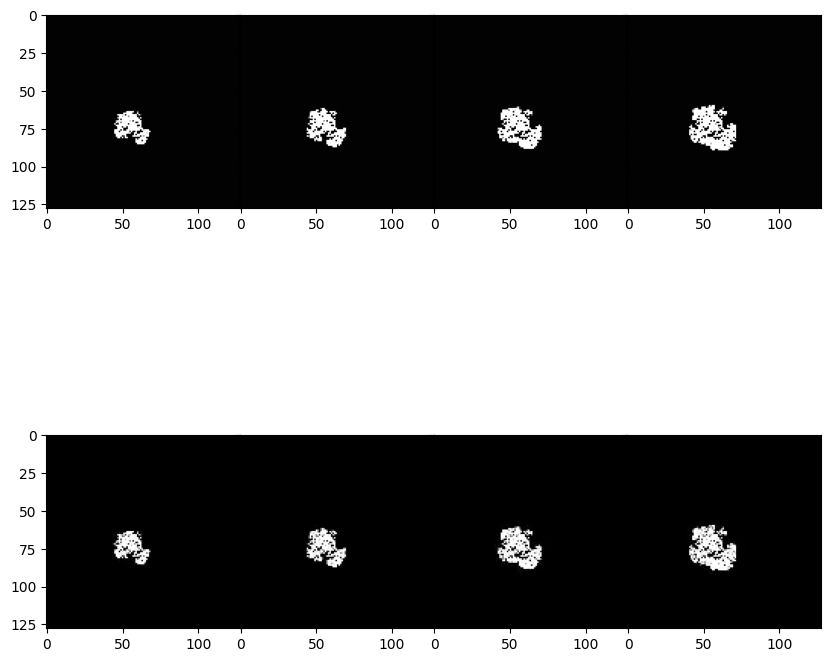

In [ ]:
seq_recon = torch.squeeze(test_recon,1).cpu().numpy()
print(seq_recon.shape)
seq_original = torch.squeeze(test_seq_in_tensor,1).cpu().numpy()
display_seq(seq_recon[35,:,:,:], seq_original[35,:,:,:])

In [ ]:
class vidLSTM(nn.Module):
    def __init__(self, input_size, hidden_multiplier):
        super(vidLSTM, self).__init__()
        hidden_size = input_size * hidden_multiplier 
        output_size = input_size
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers=1)
        nn.BatchNorm3d(input_size)
        self.decoder = nn.LSTM(hidden_size, output_size,num_layers=1)

    def forward(self,x):
        # print("1 " + str(x.shape))
        _, (hidden, cell) = self.encoder(x)
        # print("2 " + str(x.shape))
        output, (hidden, cell)  = self.decoder(x, (hidden, cell))
        # print("3 " + str(x.shape))

        return output
    




seq_indices = torch.randperm(len(train_seq_in_tensor))
train_seq_in_tensor = train_seq_in_tensor[seq_indices]
train_seq_out_tensor = train_seq_out_tensor[seq_indices]


print(train_seq_in_tensor.shape)
seq_compress.eval()
with torch.no_grad():

    train_seq_in_enc = seq_compress.enc_out(train_seq_in_tensor)
    train_seq_out_enc = seq_compress.enc_out(train_seq_out_tensor)
    test_seq_in_enc = seq_compress.enc_out(test_seq_out_tensor)
    test_seq_out_enc = seq_compress.enc_out(test_seq_out_tensor)


no_enc_features = train_seq_in_enc.shape
print(no_enc_features)




torch.Size([288, 1, 4, 128, 128])
torch.Size([288, 50])


In [ ]:
print('Device: {0}'.format(device))

seq2seq_model = vidLSTM(no_enc_features[1], 1)
seq2seq_model.to(device)

criterion = nn.MSELoss()
seq_optimiser = torch.optim.Adam(seq2seq_model.parameters(), lr = 0.1)

no_epochs = 100
batch_size = 10

for epoch in range(no_epochs):
    seq2seq_model.train()
    for batch_no in range(0,len(train_seq_in_enc), batch_size):
            
            in_batch = train_seq_in_enc[batch_no:batch_no+batch_size]
            target_batch = train_seq_out_enc[batch_no:batch_no+batch_size]
            
            seq_optimiser.zero_grad()
            next_step_pred = seq2seq_model(in_batch)
            seq_loss = criterion(next_step_pred, target_batch)
            seq_loss.backward()
            seq_optimiser.step()
            

    seq2seq_model.eval()

    with torch.no_grad():
        eval_seq = seq2seq_model(test_seq_in_enc[:-41])
        loss_MSE = criterion(eval_seq,test_seq_out_enc[:-41])
        # print("Test MSE at epoch {0}: ".format(epoch+1) + str(test_loss.item()))
        loss_RMSE = torch.sqrt(loss_MSE)
        print("Test MSE at epoch {0}: ".format(epoch+1) + str(loss_MSE.item()))





Device: cuda
Test MSE at epoch 1: 3204.963623046875
Test MSE at epoch 2: 3203.439697265625
Test MSE at epoch 3: 3203.26123046875
Test MSE at epoch 4: 3203.177978515625
Test MSE at epoch 5: 3201.095947265625
Test MSE at epoch 6: 3201.0166015625
Test MSE at epoch 7: 3201.024658203125
Test MSE at epoch 8: 3200.917236328125
Test MSE at epoch 9: 3200.918212890625
Test MSE at epoch 10: 3200.927001953125
Test MSE at epoch 11: 3200.9267578125
Test MSE at epoch 12: 3200.99853515625
Test MSE at epoch 13: 3200.9267578125
Test MSE at epoch 14: 3200.925048828125
Test MSE at epoch 15: 3200.925048828125
Test MSE at epoch 16: 3200.925048828125
Test MSE at epoch 17: 3200.19873046875
Test MSE at epoch 18: 3200.061767578125
Test MSE at epoch 19: 3200.061767578125
Test MSE at epoch 20: 3200.061767578125
Test MSE at epoch 21: 3200.061767578125
Test MSE at epoch 22: 3200.303955078125
Test MSE at epoch 23: 3200.27490234375
Test MSE at epoch 24: 3200.169921875
Test MSE at epoch 25: 3200.118408203125
Test MSE 

torch.Size([40, 50])
1 torch.Size([81, 50])
2 torch.Size([81, 50])
3 torch.Size([81, 50])
(81, 4, 128, 128)


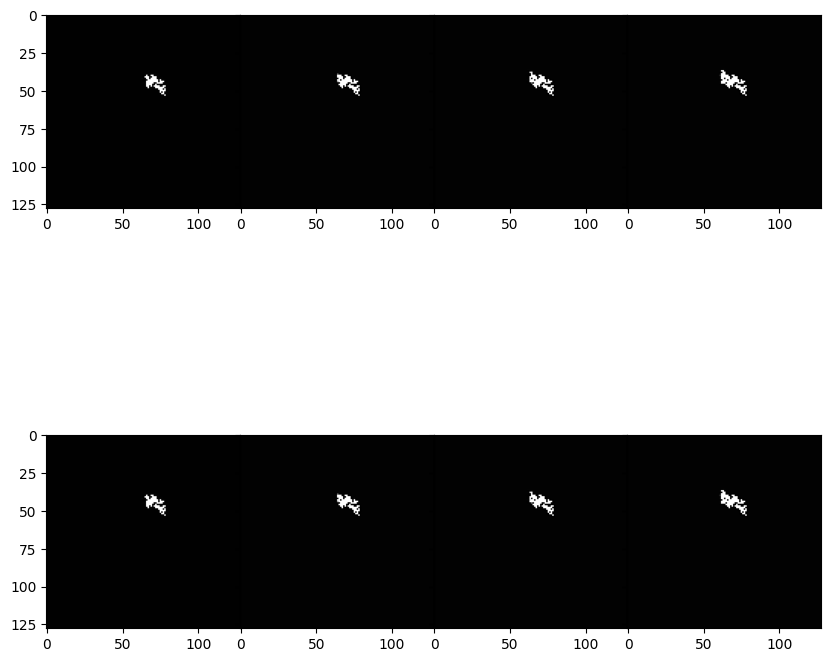

In [ ]:
print(eval_seq.shape)
beep = torch.squeeze(seq_compress.dec_out(seq2seq_model(test_seq_in_enc)).cpu(), 1).numpy()
boop = torch.squeeze(seq_compress.dec_out(test_seq_out_enc).cpu(), 1).numpy()
print(beep.shape)

display_seq(beep[7,:,:,:],boop[7,:,:,:] )

Vision transformer method:


#### Sources
1. Guo, Xifeng & Liu, Xinwang & Zhu, En & Yin, Jianping. (2017). Deep Clustering with Convolutional Autoencoders. 373-382. 10.1007/978-3-319-70096-0_39. 
